In [ ]:
#MATHEMATICAL FINANCE PROJECT
#Optimization of portfolio under dependence uncertainty via neural networks and penalization using the optimal transport framework
#Farzane Hoseini
#Mohammad Soori

In [20]:
#Importing the libraries and setting the devices

import tensorflow as tf
import numpy as np
import time
import random
import math
import matplotlib.pyplot as plt
import math as math
# Check if GPU is available and if so, set the device
if tf.config.experimental.list_physical_devices("GPU"):
    print("GPU available. Using GPU for calculations.")
    device = '/GPU:0'
else:
    print("GPU not available. Using CPU for calculations.")
    device = '/CPU:0'

GPU available. Using GPU for calculations.


In [1]:

def generate_theta_1(size):  #reference measure theta(1) which is theta1 * theta2
  points=np.zeros([size,2])
  points[:,0]=np.random.random_sample(size)  #theta1
  points[:,1]=2*(np.random.random_sample(size)**2) #theta2

  return points

def generate_theta_2(size):  #reference measure theta(2) which is 0.5*theta(2) + 0.5* samedef gen_points_1(batch_size):
        dataset = np.zeros([size, 2])
        dataset[:, 0] = np.random.random_sample(size)
        dataset[:round(size/2), 1] = 2 * ((np.random.random_sample(round(size/2))) ** 2)
        dataset[round(size/2):, 1] = 2 * (dataset[round(size/2):, 0] ** 2)
        return dataset

def create_model(m=64):  #Creating the uni-varaite functions h_1 and h_2 as DNN models
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(m, input_shape=(1,), activation='relu',
                              kernel_initializer=tf.random_uniform_initializer(minval=-1, maxval=1),
                              bias_initializer=tf.random_uniform_initializer(minval=-1, maxval=1)),
        tf.keras.layers.Dense(m, activation='relu',
                              kernel_initializer=tf.random_uniform_initializer(minval=-1, maxval=1),
                              bias_initializer=tf.random_uniform_initializer(minval=-1, maxval=1)),
        tf.keras.layers.Dense(m, activation='relu',
                              kernel_initializer=tf.random_uniform_initializer(minval=-1, maxval=1),
                              bias_initializer=tf.random_uniform_initializer(minval=-1, maxval=1)),
        tf.keras.layers.Dense(1,
                              kernel_initializer=tf.random_uniform_initializer(minval=-1, maxval=1))
    ])
    return model

def create_models(m=64):
    h1 = create_model(m)
    h2 = create_model(m)
    return h1, h2

# Define the function h
def h(data,h1,h2):
  x_1=data[:,0:1]
  x_2=data[:,1:2]
  h_1= h1(x_1)
  h_2= h2(x_2)
  return h_1 + h_2

def integral_h(data,h1,h2):
  return tf.reduce_mean(h(data,h1,h2))

def portfolio_return(x1,x2, w):  # w is the weight for the second portfolio
  return (1-w)*x1 + w*x2


def variance(input):
  mean=tf.reduce_mean(input)
  return (input-mean)**2

def f(portfolio_return,landa):
  return portfolio_return-landa*variance(portfolio_return)


def no_short_selling_penalty(w):
  return 100 * tf.nn.relu(-w) + 100 * tf.nn.relu((w-1))

def integral_beta(gamma,landa,data,w,h1,h2):
  output= tf.reduce_mean( (1/gamma)* tf.square(gamma*tf.nn.relu(((-f(portfolio_return(data[:,0:1],data[:,1:2],w),landa)-h(data,h1,h2))))))
  return output

def target_function(data,size,gamma,landa,w,h1,h2,no_short_selling=True):

  temp= integral_h(data,h1,h2) + integral_beta(gamma,landa,data,w,h1,h2)
  if no_short_selling:
    temp+=no_short_selling_penalty(w)
  return temp

def analytical_portfolio(landa, no_short_selling=True):
  if landa==0:
    return 1
  if landa==1:
    return 0

  temp = 15*(1-landa)/(19*landa)

  if temp>1 and no_short_selling:
    temp=1

  return temp

def analytical_optimal_value(landa):
  w=analytical_portfolio(landa)
  return (0.5+ w/6 -landa*(1/12 + w/6 + (19*w**2)/180))

In [15]:
#Specifying the hyperparameters

gamma=160
size=2**13
learning_rate=0.001
beta1=0.99
beta2=0.995
epochs=10000
tol_h = 1e-5
m=32
num_experiments=1

In [16]:

#The main tranining loop of the neural networks

def training(landa,measure):
    with tf.device(device):
        final_w_values = []
        for i in range(num_experiments):
            print("Starting experiment", i + 1)

            h1, h2 = create_models(m)
            w = tf.Variable(0.5)

            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)
            if measure=="theta1":
              data=generate_theta_1(size)
            elif measure=="theta2":
              data = generate_theta_2(size)
            else:
              print("Wrong measure")

            loss_values_h = []
            recorded_loss = 1e8

            for epoch in range(epochs):
                Flag=False
                with tf.GradientTape() as tape:
                    loss = target_function(data, size, gamma, landa, w, h1, h2)

                grads = tape.gradient(loss, h1.trainable_variables + h2.trainable_variables + [w])
                optimizer.apply_gradients(zip(grads, h1.trainable_variables + h2.trainable_variables + [w]))
                loss_values_h.append(loss.numpy())

                if epoch % 1000 == 0:
                    print('Epoch:', epoch, 'Loss for h1 and h2 and w:', loss.numpy())
                    if abs(recorded_loss-loss)<tol_h:
                      Flag=True
                    recorded_loss=loss.numpy()

                prev_w = w.numpy()

            if not Flag:
              final_w_values.append(w.numpy())
              print("Optimal w for experiment", i + 1, ":", w.numpy())
            else:
              print("This is a case a vanishing gradients")
              break

            plt.figure(figsize=(12, 6))
            plt.plot(loss_values_h)
            plt.title('Loss for h1 and h2 and w for experiment ' + str(i+1))
            plt.show()

        mean_w = np.mean(final_w_values)
        return mean_w


In [17]:
#getting the optimal values from neural networks and the anaytical methods and storing them for ploting.
def run_experiments(lambdas,measure):
    nn_optimal_w_values_placeholder = []
    analytical_optimal_w_values = []
    for landa in lambdas:
        nn_optimal_w = training(landa,measure)
        nn_optimal_w_values_placeholder.append(nn_optimal_w)

        analytical_optimal_w = analytical_portfolio(landa)  # Assuming this function is defined
        analytical_optimal_w_values.append(analytical_optimal_w)

    return nn_optimal_w_values_placeholder, analytical_optimal_w_values


In [24]:
#Getting the results of the experiments

lambdas = np.arange(0.07, 1.001, 0.2)  # 0 to 1 with increments of 0.2
nn_optimal_w_values_theta1, analytical_optimal_w_values = run_experiments(lambdas,"theta1")
nn_optimal_w_values_theta2,_ = run_experiments(lambdas,"theta2")

Starting experiment 1
Epoch: 0 Loss for h1 and h2 and w: 40460.367


KeyboardInterrupt: ignored

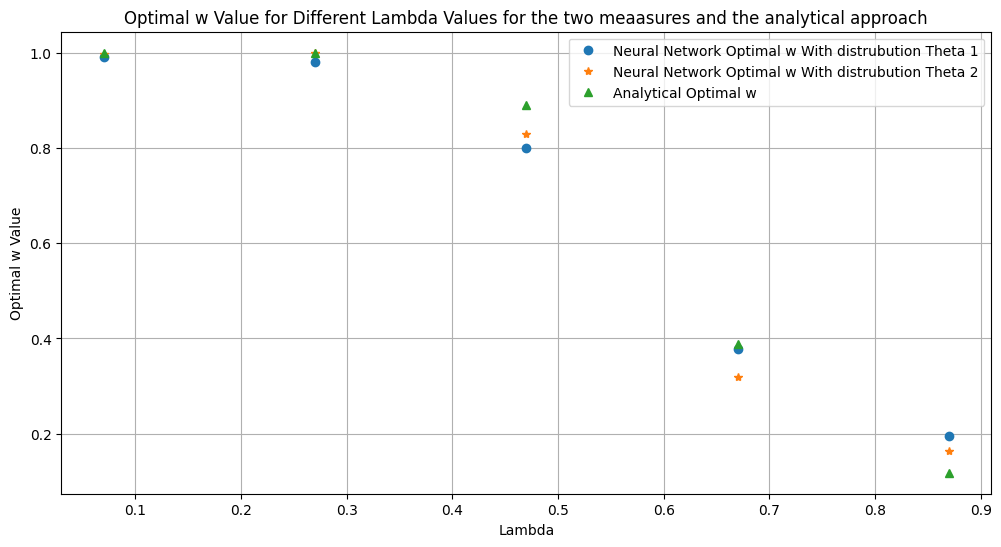

In [25]:
#Plotting the results

plt.figure(figsize=(12, 6))
plt.plot(lambdas, nn_optimal_w_values_theta1, 'o', label='Neural Network Optimal w With distrubution Theta 1')
plt.plot(lambdas,nn_optimal_w_values_theta2,"*",label="Neural Network Optimal w With distrubution Theta 2")
plt.plot(lambdas, analytical_optimal_w_values, '^', label='Analytical Optimal w')
plt.xlabel('Lambda')
plt.ylabel('Optimal w Value')
plt.title('Optimal w Value for Different Lambda Values for the two meaasures and the analytical approach')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Huristic training for trying out different values of m and gamma faster

def train_model(gamma, landa, size, learning_rate, beta1, beta2, epochs, epochs_w, learning_rate_w, tol_h, num_experiments, m,num_fixed_w_iterations=10):
    with tf.device(device):
      # Prepare a list to store the final w values
      final_w_values = []

      # Start the experiments
      for i in range(num_experiments):
          print("Starting experiment", i + 1)

          # Prepare lists to store the models for each fixed w iteration
          h1_models = []
          h2_models = []

          # Generate new data for each experiment
          data = generate_theta_2(size)

          # Fixed w iterations
          for j in range(num_fixed_w_iterations):
              # Reset the models for each fixed w iteration
              h1, h2 = create_models(m)
              w = tf.Variable(random.uniform(0, 1))
              print("Fixed w for iteration", j + 1, ":", w.numpy())

              # Define the optimizer in the loop
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)

              # Prepare a list to store the loss values for this training iteration
              loss_values = []

              # Training loop for h1 and h2
              for epoch in range(epochs):
                  with tf.GradientTape() as tape:
                      loss = target_function(data, size, gamma, landa, w, h1, h2)

                  grads = tape.gradient(loss, h1.trainable_variables + h2.trainable_variables)
                  optimizer.apply_gradients(zip(grads, h1.trainable_variables + h2.trainable_variables))

                  # Store the loss value at this epoch
                  loss_values.append(loss.numpy())

                  # Print the loss value every 10 epochs
                  if epoch % 100 == 0:
                      print('Epoch:', epoch, 'Loss for h1 and h2:', loss.numpy())

              # Plot the loss values for this training iteration
              plt.figure(figsize=(10, 6))
              plt.plot(loss_values)
              plt.xlabel('Epoch')
              plt.ylabel('Loss')
              plt.title('Loss values during training for fixed w iteration ' + str(j + 1))
              plt.grid(True)
              plt.show()

              # Store the models for this fixed w iteration
              h1_models.append(h1)
              h2_models.append(h2)

          # Create new models with parameters averaged from all the trained models
          h1_avg = create_model(m)
          h2_avg = create_model(m)
          for var_i in range(len(h1_avg.trainable_variables)):
              h1_avg.trainable_variables[var_i].assign(tf.reduce_mean([model.trainable_variables[var_i] for model in h1_models], axis=0))
              h2_avg.trainable_variables[var_i].assign(tf.reduce_mean([model.trainable_variables[var_i] for model in h2_models], axis=0))

          # Define the optimizer for w
          optimizer_w = tf.keras.optimizers.Adam(learning_rate=learning_rate_w, beta_1=beta1, beta_2=beta2)

          # Reset w for optimization
          w = tf.Variable(0.5)
          print("Initial w for optimization:", w.numpy())

          # Prepare a list to store the loss values for the w optimization
          loss_values_w = []

          # Training loop for w
          for epoch in range(epochs_w):
              with tf.GradientTape() as tape:
                  loss = target_function(data, size, gamma, landa, w, h1_avg, h2_avg)

              grads_w = tape.gradient(loss, [w])
              optimizer_w.apply_gradients(zip(grads_w, [w]))

              # Store the loss value at this epoch
              loss_values_w.append(loss.numpy())

              # Print the loss value every 10 epochs
              if epoch % 100 == 0:
                  print('Epoch:', epoch, 'Loss for w:', loss.numpy())

          # Plot the loss values for the w optimization
          plt.figure(figsize=(10, 6))
          plt.plot(loss_values_w)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Loss values during w optimization')
          plt.grid(True)
          plt.show()

          # Record the optimal w value for this experiment
          final_w_values.append(w.numpy())
          print("Optimal w for experiment", i + 1, ":", w.numpy())

      # Compute and print the mean of the optimal w values
      mean_w = np.mean(final_w_values)
      print("Mean of optimal w values:", mean_w)

      # Calculate the analytical optimal
      analytical_w = analytical_portfolio(landa)
      print("Analytical optimal w:", analytical_w)

      return mean_w
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the sets of parameters
parameters = [
    {"gamma": 5, "landa": 0.8, "size": 2**5, "learning_rate": 0.01, "beta1": 0.90, "beta2": 0.995, "epochs": 100, "epochs_w": 40, "learning_rate_w": 0.1, "tol_h": 1e-5, "num_experiments": 10, "m": 2, "num_fixed_w_iterations":5},
    {"gamma": 10, "landa": 0.8, "size": 2**7, "learning_rate": 0.01, "beta1": 0.93, "beta2": 0.995, "epochs": 150, "epochs_w": 80, "learning_rate_w": 0.1, "tol_h": 1e-5, "num_experiments": 10, "m": 4,"num_fixed_w_iterations":5},
    {"gamma": 20, "landa": 0.8, "size": 2**9, "learning_rate": 0.001, "beta1": 0.96, "beta2": 0.995, "epochs": 200, "epochs_w": 80, "learning_rate_w": 0.01, "tol_h": 1e-5, "num_experiments": 10, "m": 8,"num_fixed_w_iterations":10},
    {"gamma": 40, "landa": 0.8, "size": 2**11, "learning_rate": 0.0001, "beta1": 0.99, "beta2": 0.995, "epochs": 250, "epochs_w": 100, "learning_rate_w": 0.01, "tol_h": 1e-5, "num_experiments": 10, "m": 16,"num_fixed_w_iterations":10}
]

# Prepare lists to store the mean w values, m values, and gamma values
mean_w_values = []
m_values = []
gamma_values = []

# Calculate the mean w value for each set of parameters
with tf.device(device):
  for param in parameters:
      mean_w = train_model(**param)
      mean_w_values.append(mean_w)
      m_values.append(param["m"])
      gamma_values.append(param["gamma"])

# Plot the mean of optimal w values for different values of m
plt.figure(figsize=(10, 6))
plt.plot(m_values, mean_w_values, 'o-')
plt.xlabel('m')
plt.ylabel('Mean of optimal w values')
plt.title('Mean of optimal w values for different values of m')
plt.grid(True)
plt.show()

# Plot the mean of optimal w values for different values of gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, mean_w_values, 'o-')
plt.xlabel('gamma')
plt.ylabel('Mean of optimal w values')
plt.title('Mean of optimal w values for different values of gamma')
plt.grid(True)
plt.show()

# Plot the mean of optimal w values for different values of m and gamma
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m_values, gamma_values, mean_w_values)
ax.set_xlabel('m')
ax.set_ylabel('gamma')
ax.set_zlabel('Mean of optimal w values')
plt.title('Mean of optimal w values for different values of m and gamma')
plt.show()